In [67]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
from sklearn import mixture



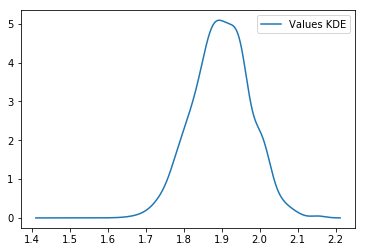

In [68]:
#draw data
n=2000

bids = np.concatenate((np.random.normal(loc=1.7, scale=0.06, size=int(.8*n)), 
                      np.random.normal(loc=1.9, scale=0.07, size=int(.2*n))))

#fit mixture model
g = mixture.GaussianMixture(n_components=2)
g.fit(bids.reshape(n,1))
ind =  np.argmax(g.means_, axis=0)[0]


#print values given competitive distribution
i = 7
g1 = lambda b: stats.norm.pdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)
G1 = lambda b: stats.norm.pdf(b,g.means_[ind,0],g.covariances_[ind,0]**.5)
values = bids + 1/(i-1)*G1(bids)/g1(bids)

#KDE_weighted
q = g.predict_proba(bids.reshape(n,1))[:,ind]
kde = sm.nonparametric.KDEUnivariate(values)

kde.fit(weights=q, fft=False)
plt.plot(kde.support, kde.density, label='Values KDE')

plt.legend()
plt.show()

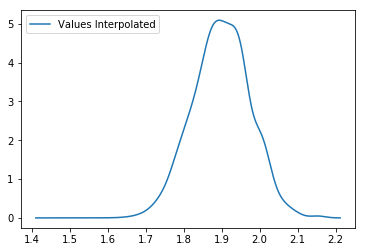

In [83]:
#set up values distribution as a rv
values_dist = scipy.stats.rv_continuous()
values_dist.cdf  = scipy.interpolate.interp1d(kde.support, kde.cdf, fill_value="extrapolate")
values_dist.pdf = scipy.interpolate.interp1d(kde.support,  kde.density, fill_value="extrapolate")


plt.plot(kde.support, f(kde.support), label='Values Interpolated')
plt.legend()
plt.show()

In [84]:
def pi_l(p, vs, i, dist, supp):
    """lower bound for profits"""
    return vs*dist.cdf(p)**i + i*p*(1-dist.cdf(p))*dist.cdf(p)**(i-1)


def pi_u(p, vs, i, dist, supp):
    """upper bound for profits"""
    integrand = lambda v:(1-dist.cdf(v))*v*dist.pdf(v)**(i-1)
    surplus = []
    for q in p:
        surplus.append( scipy.integrate.quad(integrand, q, supp[1])[0] )
    return pi_l(p, vs, i, dist, supp) + np.array(surplus)

def pi_opt(vs, i, dist, supp):
    """argmax of lower bound"""
    obj = lambda p: -pi_l(p, vs, i, dist, supp)
    result = scipy.optimize.minimize(obj, sum(supp)/2.)
    return result.x, -1*obj(result.x)


def pi_est(vs, i, dist, supp):
    """calculate the """
    argmax, maxim = pi_opt(vs, i, dist, supp)
   
    obj = lambda p:(pi_u(p, vs, i, dist, supp) - maxim)**2

    bnds1 = [(supp[0],argmax)]
    result1 = scipy.optimize.minimize(obj, argmax*.9, bounds=bnds1 )
    
    bnds2 = [(argmax,supp[1])]
    result2 = scipy.optimize.minimize(obj, argmax*1.1, bounds=bnds2 )

    return np.concatenate([result1.x, result2.x])

/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarn

/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/home/erichschulman/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarn

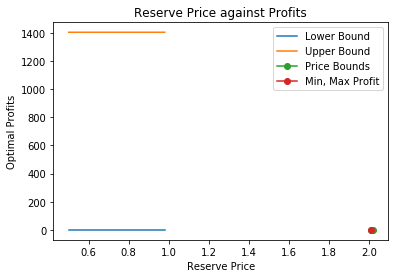

In [85]:
#overall bounds on profit
support = np.arange(.5,1.0,.02)
vs = values.min()
values_supp = (values.min(),values.max())

lb = pi_l(support, 1, i, values_dist, values_supp)
ub = pi_u(support, 1, i, values_dist, values_supp)


plt.plot(support, lb, label='Lower Bound')
plt.plot(support, ub, label='Upper Bound')

#bounds on reserve price
argmax, maxim = pi_opt(1, i, values_dist, values_supp)
p_bnds = pi_est(1, i, values_dist, values_supp)
pi_bnds = pi_u(p_bnds, 1, i, values_dist, values_supp)

plt.plot(p_bnds, pi_bnds, label='Price Bounds',marker='o')
plt.plot(argmax, maxim, label='Min, Max Profit',marker='o')


#make it pretty
plt.xlabel('Reserve Price')
plt.ylabel('Optimal Profits')
plt.title('Reserve Price against Profits')
plt.legend()
plt.show()